band - (train, test)
vv - (1.00, 0.99)
vh - ()
vhvv - ()

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
from torch.utils.data import DataLoader

sys.path.append('../../')

from src.data.data_utils import *
from src.data.dataset import *
from src.models.classifier import *

sns.set_theme()
cmap = sns.color_palette("tab10", as_cmap=True)

/u/ayang1/.conda/envs/cropts/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Loading MOMENT outputs

In [4]:
results = torch.load('results.pth', map_location=torch.device('cpu'))

In [6]:
results['classifier_results']['accuracy']

0.39039247436194

In [12]:
results['train_outputs'].keys()

dict_keys(['embeddings', 'logits', 'labels', 'keys'])

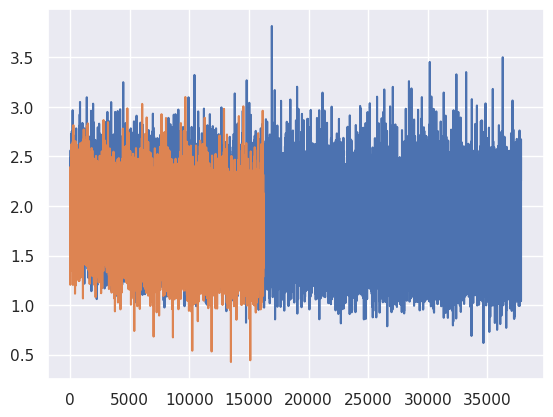

In [8]:
plt.plot(results['classifier_results']['train_losses'], label='Train Loss')
plt.plot(results['classifier_results']['test_losses'], label='Test Loss')

In [3]:
ds_path = '/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl'
output_path = os.path.join(ds_path, '0_16_test_outputs.pkl')
with open('results.', 'rb') as f:
    data = pkl.load(f)


UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [7]:
embeddings = data['embeddings']
embeddings = embeddings.mean(axis=1)

In [8]:
embeddings.shape

(12969, 3072)

In [9]:
np.save(os.path.join(ds_path, '0_16_test_embed.npy'), embeddings)
np.save(os.path.join(ds_path, '0_16_test_embed_labels.npy'), data['labels'])

Load data/model

In [3]:
results = torch.load('/scratch/bbug/ayang1/model_outputs/moment/classifier/1024_200.pth', map_location=torch.device('cpu'))
embeddings = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_embed.npy'))
labels = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_embed_labels.npy'))
test_ds = EmbeddingDataset(embeddings=embeddings, labels=labels)


In [4]:
model = CropTypeClassifier(
    input_dim=3072,
    n_classes=labels.shape[1],
    hidden_dim=1024,
    )
model.load_state_dict(results['model'])

<All keys matched successfully>

In [5]:
def test_accuracy(model, test_loader, device='cpu'):
    acc = 0
    steps = 0
    pbar = tqdm(total=len(test_loader))
    model.eval()
    
    pred = []
    true = []
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            acc += (outputs.argmax(1) == labels.argmax(1)).sum().item()
            steps += labels.shape[0]
            
            true.append(labels.argmax(1).cpu().numpy())
            pred.append(outputs.argmax(1).cpu().numpy())
            
            pbar.update(1)

    return float(acc / steps), np.concatenate(pred), np.concatenate(true)

In [6]:
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
acc, pred, true = test_accuracy(model, test_loader)
print(acc)

100%|██████████| 12969/12969 [00:20<00:00, 625.57it/s] 

0.9455624951808158


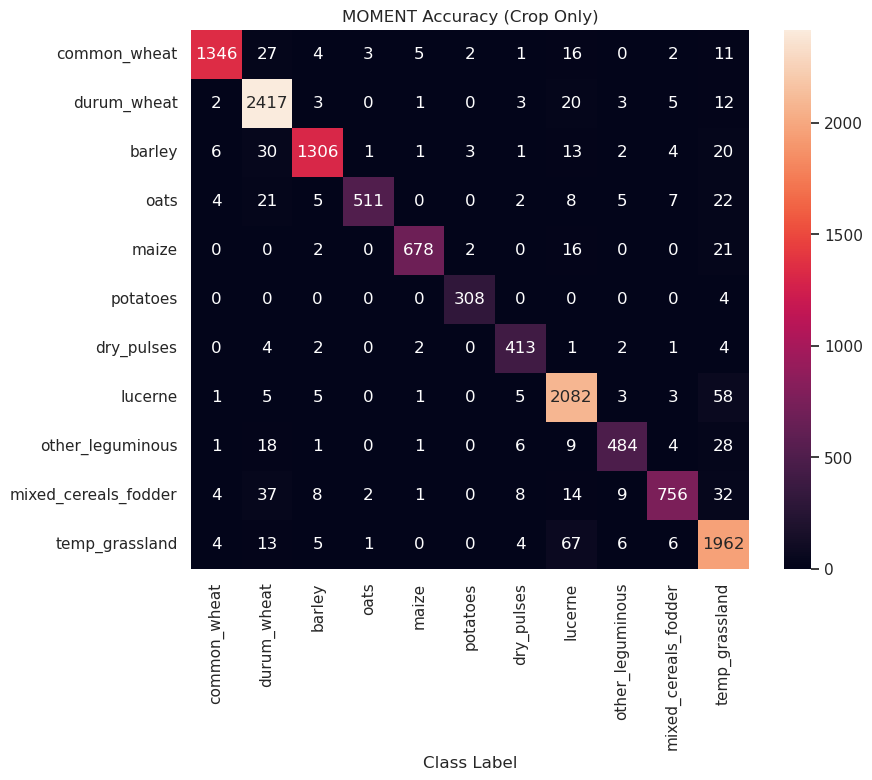

In [14]:
from sklearn.metrics import confusion_matrix

crop_ds = CropTypeDataset(
    np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_signals.npy')),
    labels = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_labels.npy'))
)
keys = crop_ds.get_keys()
reverse = dict(zip([np.argmax(x) for x in keys.values()], keys.keys()))
# labels = [reverse[x] for x in np.unique(pred)]
labels = [
    'common_wheat',
    'durum_wheat',
    'barley',
    'oats',
    'maize',
    'potatoes',
    'dry_pulses',
    'lucerne',
    'other_leguminous',
    'mixed_cereals_fodder',
    'temp_grassland'
]

def confusion_plot(pred, true, labels, title):
    cf_matrix = confusion_matrix(
        true,
        pred
        )
    
    fig = plt.figure(figsize=(9,7))
    
    sns.heatmap(
        cf_matrix, 
        annot=True, fmt='d', 
        xticklabels=labels,
        yticklabels=labels
    )
    
    plt.title(title)
    plt.xlabel('Class Label')
    plt.show()

confusion_plot(pred, true, labels, 'MOMENT Accuracy (Crop Only)')

In [8]:
from sklearn.metrics import classification_report

print(classification_report(true, pred, target_names=keys.keys()))

              precision    recall  f1-score   support

         B11       0.98      0.95      0.97      1417
         B12       0.94      0.98      0.96      2466
         B13       0.97      0.94      0.96      1387
         B15       0.99      0.87      0.93       585
         B16       0.98      0.94      0.96       719
         B21       0.98      0.99      0.98       312
         B41       0.93      0.96      0.95       429
         B52       0.93      0.96      0.94      2163
         B53       0.94      0.88      0.91       552
         B54       0.96      0.87      0.91       871
         B55       0.90      0.95      0.93      2068

    accuracy                           0.95     12969
   macro avg       0.96      0.94      0.94     12969
weighted avg       0.95      0.95      0.95     12969



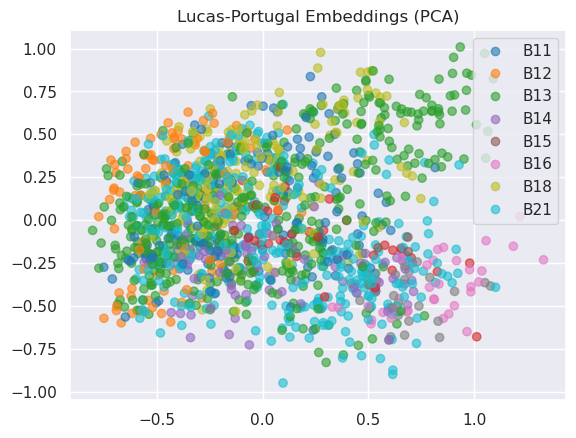

In [15]:
from sklearn.decomposition import PCA

test_embeddings_manifold = PCA(n_components=2).fit_transform(test_embeddings) 

plt.title(f"Lucas-{country} Embeddings (PCA)")
fig = plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze(),
    cmap=cmap,
    alpha=0.6,
)
plt.legend(handles=fig.legend_elements()[0], labels=keys.keys())
plt.show()

In [9]:
import numpy as np
from sklearn.manifold import TSNE

test_embeddings_manifold = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_embeddings)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd48bb04400>
Traceback (most recent call last):
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'None

AttributeError: module 'matplotlib.pyplot' has no attribute 'legend_elements'

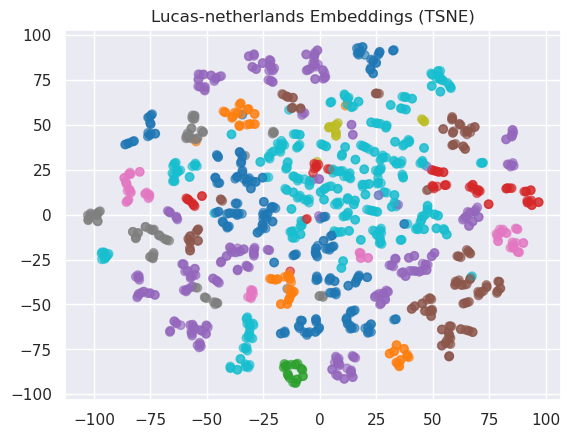

In [11]:
plt.title(f"Lucas-{country} Embeddings (TSNE)")
plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze(),
    cmap=cmap,
    alpha=0.6,
)

plt.legend(handles=plt.legend_elements()[0], labels=keys.keys())
plt.show()

### RF Classifier

In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import sys

sys.path.append('../')

from src.data.dataset import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [15]:
train_data = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'train_signals.npy'))
train_labels = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'train_labels.npy'))

crop_ds = CropTypeDataset(train_data, train_labels)
keys = crop_ds.get_keys()
reverse = dict(zip([np.argmax(x) for x in keys.values()], keys.keys()))

train_data = np.mean(train_data, axis=1)

In [16]:
from sklearn.model_selection import GridSearchCV, train_test_split

def train_rf(data, labels):
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=150
    )
    grid_search = GridSearchCV(
        rf,
        {
            'n_estimators': [100, 150, 200],
            'max_depth': [50, 100, 150, 200],
        },
        cv=5,
        n_jobs=10,
    )
    
    grid_search.fit(data, labels)
    
    return grid_search.best_estimator_


In [17]:
best = train_rf(train_data, train_labels)

0.9450998534968


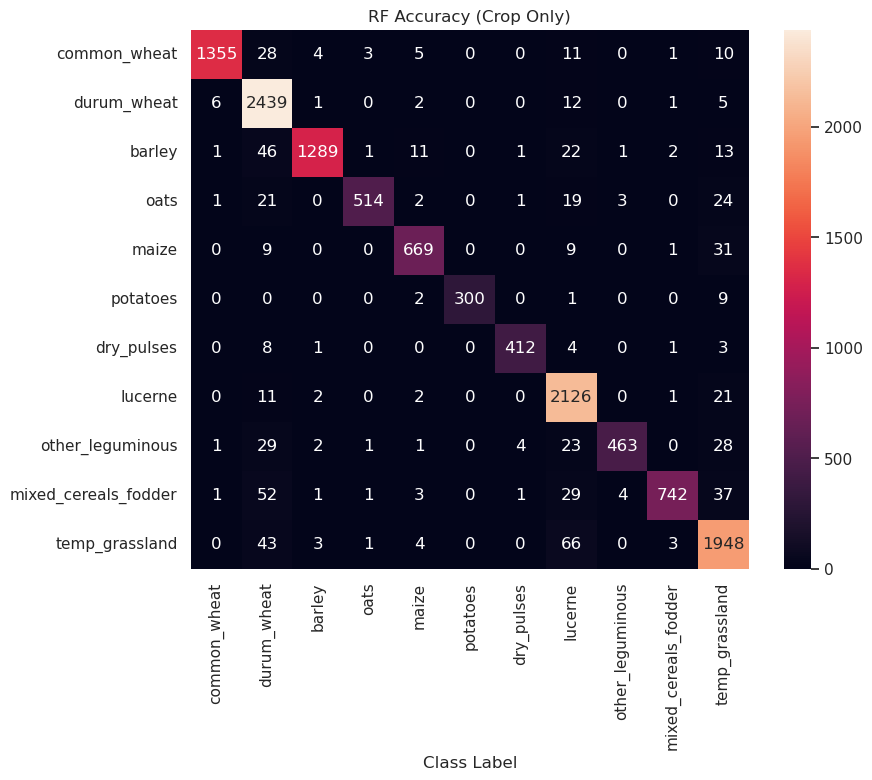

In [26]:
test_data = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_signals.npy'))
test_labels = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'test_labels.npy'))
test_data = np.mean(test_data, axis=1)

pred = best.predict(test_data)
acc = np.sum(pred == test_labels) / len(test_labels)
print(acc)


confusion_plot(pred, test_labels, labels, 'RF Accuracy (Crop Only)')

In [121]:
train_data = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'train_signals.npy'))
train_labels = np.load(os.path.join('/scratch/bbug/ayang1/datasets/lucas_dataset_ieitptnl', 'train_labels.npy'))

crop_ds = CropTypeDataset(train_data, train_labels, seq_len=16)

In [128]:
crop_ds[0][0]

tensor([[  0.1107,   0.2007,   0.1861,   0.1962,   0.2527,   0.1888,   0.2335,
           0.2893,   0.2359,   0.3851,   0.3687,   0.4364,   0.2904,   0.8679,
           0.4121,   0.2922],
        [-21.8480, -18.3562, -20.8696, -21.5315, -20.2162, -20.2048, -20.7881,
         -19.1336, -18.8721, -19.3024, -19.3267, -21.2891, -17.3762, -19.1106,
         -15.8287, -17.2690],
        [-11.5525, -11.1897, -12.8537, -14.1548, -13.7097, -12.9972, -14.0510,
         -12.9934, -12.5847, -13.4927, -14.9715, -16.2308, -11.6412, -17.1772,
         -10.4335, -10.9139]], dtype=torch.float64)

In [129]:
train_data[0,:, 0:16]

array([[  0.11068159,   0.20072438,   0.18608673,   0.19615102,
          0.25269872,   0.18877958,   0.23347768,   0.28931   ,
          0.23587587,   0.38509902,   0.3687179 ,   0.43635863,
          0.29036766,   0.86788136,   0.41212547,   0.29219753],
       [-21.847988  , -18.356186  , -20.869644  , -21.531475  ,
        -20.216162  , -20.204811  , -20.78807   , -19.133558  ,
        -18.872065  , -19.302422  , -19.326742  , -21.289091  ,
        -17.376165  , -19.110603  , -15.828736  , -17.268951  ],
       [-11.552536  , -11.189703  , -12.853668  , -14.154839  ,
        -13.709677  , -12.997155  , -14.051016  , -12.993397  ,
        -12.584733  , -13.4927435 , -14.971495  , -16.230762  ,
        -11.641247  , -17.177174  , -10.433487  , -10.913916  ]])